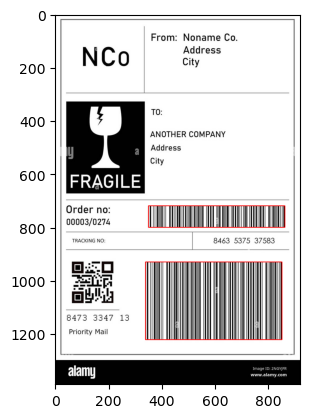

In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

def get_center(contour):
    M = cv2.moments(contour)
    cX = int(M["m10"] / max(M["m00"], 1e-6))
    cY = int(M["m01"] / max(M["m00"], 1e-6))
    return cX, cY

def find_rectangles(img):
    filtered = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8) 
    img = cv2.GaussianBlur(img, (5, 5), 0)
    for gray in cv2.split(img):
        for thrs in range(50, 200, 1):
            _retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, h = cv2.findContours(~bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
            contours = [contours[i] for i in range(len(contours)) if h[0][i][3] == -1]
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                poly = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                w, h = cv2.minAreaRect(cnt)[1]
                if len(poly) <= 8 and cv2.contourArea(cnt) > 10 and cv2.contourArea(poly) < 1000 and (h / w) > 5:
                    cv2.drawContours(filtered, [cnt], -1, 255, -1)
    return filtered

def dist(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) 

def findBarCodes(image):
    thresh = find_rectangles(image)  # Find rectangles in the image
    contours, h = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted([contours[i] for i in range(len(contours)) if h[0][i][3] == -1], key=lambda x: cv2.boundingRect(x)[0])

    groups = []

    # Group rectangles based on proximity and size similarity
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        center_1 = get_center(cnt)
        found = False
        if w * h > 50 and w * h < thresh.shape[0] * thresh.shape[1] / 2:
            for group in groups:
                x2, y2, w2, h2 = cv2.boundingRect(group[-1])
                center_2 = get_center(group[-1])
                if abs(center_1[1] - center_2[1]) < 20 and (abs(h - h2) / max(h, h2)) < 0.3 and any(map(lambda p: dist((x, y), p) < 20, [(x2, y2), (x2 + w2, y2), (x2, y2 + h2), (x2 + w2, y2 + h2)])):
                    group.append(cnt)
                    found = True
                    break
            if not found:
                groups.append([cnt])

    # Remove groups with estimated bar count less than 10
    for group in groups[:]:
        mn = 1000000
        total = 0
        for c in group:
            x, y, w, h = cv2.boundingRect(c)
            total += w * h
            mn = min(mn, w * h)
        estimatedBars = total / mn
        if estimatedBars < 10:
            groups.remove(group)

    # Draw rectangles around barcode regions
    for idx, group in enumerate(groups):
        boxes = []
        for c in group:
            x, y, w, h = cv2.boundingRect(c)
            boxes.append([x, y, x + w, y + h])
            cv2.rectangle(thresh, (x, y), (x + w, y + h), 255, 2)
            cv2.putText(thresh, str(idx), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 255, 2)
            cv2.drawContours(thresh, [c], -1, 128, -1)

        boxes = np.asarray(boxes)

        left = np.min(boxes[:, 0])
        top = np.min(boxes[:, 1])
        right = np.max(boxes[:, 2])
        bottom = np.max(boxes[:, 3])

        cv2.rectangle(image, (left, top), (right, bottom), 255, 2)

    # Return the image with barcode regions highlighted
    return image

# Example usage
highlighted_image = findBarCodes(cv2.imread('/home/snucse/Music/Bill.jpg'))

# Display the highlighted image separately
plt.imshow(highlighted_image)
plt.show()


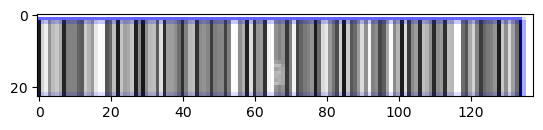

In [6]:
def printHighlightedArea(image1):
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask
    _, binary_mask = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Extract the highlighted area from the original image
    highlighted_area = image[y:y+h, x:x+w]

    # Print the highlighted area
    plt.imshow(cv2.cvtColor(highlighted_area, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
image_with_highlighted_barcode = cv2.imread('/home/snucse/Music/Bill.jpg')
highlighted_image = findBarCodes(image_with_highlighted_barcode)
printHighlightedArea(highlighted_image)

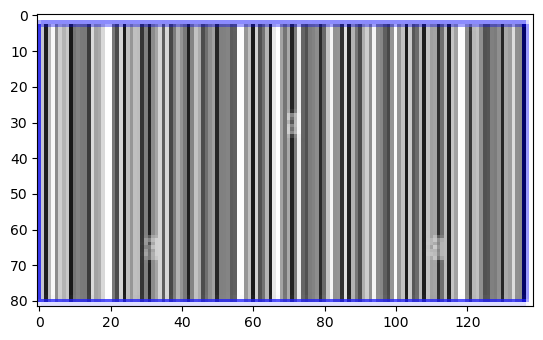

In [4]:
def printHighlightedArea(image2):
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a binary mask
    _, binary_mask = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Extract the highlighted area from the original image
    highlighted_area = image[y:y+h, x:x+w]

    # Print the highlighted area
    plt.imshow(cv2.cvtColor(highlighted_area, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
image_with_highlighted_barcode = cv2.imread('/home/snucse/Music/Bill.jpg')
highlighted_image = findBarCodes(image_with_highlighted_barcode)
printHighlightedArea(highlighted_image)